In [1]:
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from genomics.popgen.admix import cluster, plot
import numpy as np
import xarray as xr
import sgkit as sg
from sgkit.io import plink
from genomics.popgen.plink.convert import to_eigen
from genomics.popgen.pca import plot, smart
from pprint import pprint
import seaborn as sns
import pandas as pd

/home/veysel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [8]:
!wget https://ftp.ncbi.nlm.nih.gov/hapmap/genotypes/hapmap3_r3/plink_format/hapmap3_r3_b36_fwd.consensus.qc.poly.map.gz
!wget https://ftp.ncbi.nlm.nih.gov/hapmap/genotypes/hapmap3_r3/plink_format/hapmap3_r3_b36_fwd.consensus.qc.poly.ped.gz

!wget https://ftp.ncbi.nlm.nih.gov/hapmap/genotypes/hapmap3_r3/relationships_w_pops_041510.txt


!gzip -d hapmap3_r3_b36_fwd.consensus.qc.poly.map.gz
!gzip -d hapmap3_r3_b36_fwd.consensus.qc.poly.ped.gz

--2025-02-04 00:10:00--  https://ftp.ncbi.nlm.nih.gov/hapmap/genotypes/hapmap3_r3/plink_format/hapmap3_r3_b36_fwd.consensus.qc.poly.map.gz
130.14.250.12, 130.14.250.31, 130.14.250.11, ....gov)... 
connected. to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 11319129 (11M) [application/x-gzip]
Saving to: ‘hapmap3_r3_b36_fwd.consensus.qc.poly.map.gz’

hapmap3_r3_b36_fwd. 100%[===================>]  10.79M  27.0MB/s    in 0.4s    

2025-02-04 00:10:01 (27.0 MB/s) - ‘hapmap3_r3_b36_fwd.consensus.qc.poly.map.gz’ saved [11319129/11319129]

--2025-02-04 00:10:01--  https://ftp.ncbi.nlm.nih.gov/hapmap/genotypes/hapmap3_r3/plink_format/hapmap3_r3_b36_fwd.consensus.qc.poly.ped.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

## **Managing Datasets with PLINK**

I will use data from the International HapMap Project, a precursor to the 1,000 Genomes Project. Unlike whole-genome sequencing, the HapMap Project relied on genotyping. Many samples from HapMap were later included in the 1,000 Genomes Project.

Since the HapMap dataset is smaller and more manageable, it is useful for learning population genetics programming techniques in Python. However, for actual research in human population genetics, the 1,000 Genomes Project is recommended.

The HapMap project includes genotyping data from various global populations, referred to by the following acronyms:

- **ASW**: African ancestry in Southwest USA  
- **CEU**: Utah residents with Northern/Western European ancestry  
- **CHB**: Han Chinese in Beijing, China  
- **CHD**: Chinese in Metropolitan Denver, Colorado  
- **GIH**: Gujarati Indians in Houston, Texas  
- **JPT**: Japanese in Tokyo, Japan  
- **LWK**: Luhya in Webuye, Kenya  
- **MXL**: Mexican ancestry in Los Angeles, California  
- **MKK**: Maasai in Kinyawa, Kenya  
- **TSI**: Toscani in Italy  
- **YRI**: Yoruba in Ibadan, Nigeria  

For more details, you can refer to the HapMap Project site:  
[HapMap Project](https://www.genome.gov/10001688/international-hapmap-project)


### **Overall Objective**

The overall aim of this series of steps is to transform the raw HapMap genotyping data (which comes in PLINK PED/MAP format and includes population metadata in separate files) into a series of curated datasets that meet the requirements of population genetic analyses. These curated datasets include:

   **Subsampled datasets:** To reduce computational load and for exploratory purposes.
    
   **Autosome-only datasets:** To remove non-autosomal markers (e.g., sex chromosomes, mitochondria) that might not be suitable for some analyses.

   **Unrelated individual datasets:** To avoid biases that come from analyzing related individuals.

   **LD-pruned datasets:** To satisfy assumptions of methods that require markers to be in linkage equilibrium.

   **Recoded datasets:** In various formats (numeric, binary) that are suitable for different downstream analysis methods (such as PCA or admixture analysis).

This process is typical in population genetics research—especially when using legacy datasets like HapMap—as it helps ensure that the data meets the assumptions of various statistical and computational methods while also reducing the dataset to a manageable size.
Final Note

This workflow, although implemented via system calls to PLINK2 and Python scripting, is primarily about data curation: filtering out unwanted markers, selecting the most informative subset of markers, and reformatting the data so that it can be effectively used in population genetics studies.

# 1. The PED File

## a. Definition and Purpose

**PED** stands for **Pedigree file**.  
It is a plain text (ASCII) file that contains both **genotype data** and **pedigree (family relationship) information** for each individual.

## b. Structure

A **PED file** is typically a space‐ or tab‐delimited text file with one row per individual. The standard format includes:

- **Family ID:**  
  A unique identifier for the family or pedigree that the individual belongs to.

- **Individual ID:**  
  A unique identifier for the individual.

- **Paternal ID:**  
  The identifier for the individual’s father. If not available, a placeholder (often `0`) is used.

- **Maternal ID:**  
  The identifier for the individual’s mother. If not available, a placeholder is used.

- **Sex:**  
  Encoded typically as `1` for male, `2` for female, and sometimes `0` or other codes for unknown.

- **Phenotype:**  
  A value representing the trait or disease status; sometimes a quantitative value, or `-9` or `0` if missing.

- **Genotype Data:**  
  Following these six fields, the file contains genotype information for each marker (SNP).
  
  - **Format:**  
    For each SNP, two columns are present (one for each allele), usually represented by letters (`A, C, G, T`) or numeric codes.
    
  - **Example (for one SNP):**  
    - `A A` for homozygous reference  
    - `A C` for heterozygous  
    - `C C` for homozygous alternate

  - **Order:**  
    The genotype data for all markers are concatenated, so the total number of columns in the file is:

    \[
    6 + (2 \times \text{number of markers})
    \]

## c. Pros and Cons

### **Pros**
- **Human-readable:**  
  Being a text file, it is easy to inspect and modify using standard text editors or command-line tools.
- **Flexibility:**  
  Contains both genotype and pedigree information in one file.

### **Cons**
- **Large File Size:**  
  For large datasets (many individuals and markers), PED files can become very large and slow to parse.
- **Inefficiency:**  
  Text-based storage is less efficient in both space and processing speed compared to binary formats.

---

# 2. The BED File

## a. Definition and Purpose

**BED** stands for **Binary PED file**.  
It is a compact, binary file format used by **PLINK** to store genotype data in a much more efficient way than the text-based **PED file**.

BED files are used in combination with:

- **BIM file:**  
  Contains marker (SNP) information such as marker names, chromosome, genetic distance, physical position, and allele coding.

- **FAM file:**  
  Contains pedigree information (similar to the first six columns in the **PED file**).

## b. Structure

### **BED File**
- Stores the genotype information in **binary** form.
- Uses **two bits per genotype** (with a specific encoding scheme) to represent the two alleles of a SNP.
- The file has a specific **header** (a “magic number”) that identifies it as a **PLINK binary file**.

### **BIM File**
A **tab-delimited** text file with **one row per SNP**.  
Contains information such as:

- **Chromosome number**
- **SNP identifier**
- **Genetic distance** (often set to `0` if not available)
- **Physical position** (in base pairs)
- **Alleles** (usually two columns indicating the reference and alternate allele)

### **FAM File**
A **tab-delimited** text file with **one row per individual**.  
Contains information such as:

- **Family ID**
- **Individual ID**
- **Paternal ID**
- **Maternal ID**
- **Sex**
- **Phenotype**

## c. Encoding of Genotypes

- In the **BED file**, genotypes are encoded with **2 bits per SNP per individual**.
- This encoding supports three states:
  - **Homozygous reference**
  - **Heterozygous**
  - **Homozygous alternate**
  - **A special code for missing data**

- Because the data are stored in **binary format**, the BED file is **much smaller** and **faster** to read and process than a **PED file**.

## d. Pros and Cons

### **Pros**
- **Efficiency:**  
  Binary storage means smaller file sizes and faster I/O.
- **Speed:**  
  Loading a BED file into memory is much faster, which is crucial for large-scale genomic analyses.
- **Standard in PLINK:**  
  The BED/BIM/FAM trio is the standard format for many genome-wide analyses in **PLINK**.

### **Cons**
- **Not Human-readable:**  
  You cannot easily inspect a **BED file** with a text editor.
- **Requires Specialized Tools:**  
  To view or manipulate **BED files**, you must use **PLINK** or other software that understands the format.


In [2]:
f = open('relationships_w_pops_041510.txt')
f.readline()  # header
cntr=0
for l in f:
    print(l)
    cntr+=1
    if cntr >5:
        break
f.close()

2427	NA19919	NA19908	NA19909	1	0	ASW

2431	NA19916	0	0	1	0	ASW

2424	NA19835	0	0	2	0	ASW

2469	NA20282	0	0	2	0	ASW

2368	NA19703	0	0	1	0	ASW

2425	NA19902	NA19900	NA19901	2	0	ASW



In [3]:
f = open('relationships_w_pops_041510.txt')
pop_ind = defaultdict(list)
offspring = []
f.readline()  # header
for l in f:
    toks = l.rstrip().split('\t')
    fam_id = toks[0]
    ind_id = toks[1]
    mom = toks[2]
    dad = toks[3]
    if mom != '0' or dad != '0':
        offspring.append((fam_id, ind_id))
    pop = toks[-1]
    pop_ind[pop].append((fam_id, ind_id))
print(toks)
print('---------------------------------------------------')
print(fam_id)
print('---------------------------------------------------')
print(ind_id)
print('---------------------------------------------------')
print(mom)
print('---------------------------------------------------')
print(dad)
print('---------------------------------------------------')
print(pop)
print('---------------------------------------------------')
print(list(pop_ind.keys()))
print('---------------------------------------------------')
f.close()

['Y076', 'NA19124', '0', '0', '1', '0', 'YRI']
---------------------------------------------------
Y076
---------------------------------------------------
NA19124
---------------------------------------------------
0
---------------------------------------------------
0
---------------------------------------------------
YRI
---------------------------------------------------
['ASW', 'CEU', 'CHB', 'CHD', 'GIH', 'JPT', 'LWK', 'MEX', 'MKK', 'TSI', 'YRI']
---------------------------------------------------


In [4]:
"""
Runs two PLINK2 commands via Python’s os.system:

    The first command uses a thinning probability of 10% (--thin 0.1).
    The second command uses a thinning probability of 1% (--thin 0.01).

Both commands use the same input file (a PED/MAP file from HapMap), 
filter out markers with high missing genotype rates (--geno 0.1, meaning markers 
with >10% missingness are removed), and export the data in PED format.
Purpose:
Subsampling the markers reduces the size of the dataset for exploratory analyses 
and for methods that do not require all markers. Because the selection is random, 
you will end up with roughly 10% and 1% of the markers, respectively.
"""
os.system('plink2 --pedmap hapmap3_r3_b36_fwd.consensus.qc.poly --out hapmap10 --thin 0.1 --geno 0.1 --export ped')
os.system('plink2 --pedmap hapmap3_r3_b36_fwd.consensus.qc.poly --out hapmap1 --thin 0.01 --geno 0.1 --export ped')

PLINK v2.00a6 AVX2 (23 Nov 2023)               www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to hapmap10.log.
Options in effect:
  --export ped
  --geno 0.1
  --out hapmap10
  --pedmap hapmap3_r3_b36_fwd.consensus.qc.poly
  --thin 0.1

Start time: Tue Feb  4 23:27:26 2025
15773 MiB RAM detected, ~10413 available; reserving 7886 MiB for main
workspace.
Using up to 8 compute threads.
--pedmap: 1457897 variants in .map file.
--pedmap: 1397 samples present, genotypes extracted to
hapmap10-temporary.bed.smaj .
Transposing sample-major .bed to hapmap10-temporary.pgen , and setting major
alleles to provisional-REF.
Pass 1/1: transposing and compressidone.
Transpose complete.
--pedmap: hapmap10-temporary.pgen + hapmap10-temporary.pvar +
hapmap10-temporary.psam written. .bed.smaj and .fam.tmp temporary files
deleted.
1397 samples (714 females, 683 males; 1198 founders) loaded from
hapmap10-temporary.psam.
1457897 variants 

2

In [5]:
# !plink2 --pedmap hapmap3_r3_b36_fwd.consensus.qc.poly --out hapmap10 --thin 0.1 --geno 0.1 --export ped
# !plink2 --pedmap hapmap3_r3_b36_fwd.consensus.qc.poly --out hapmap1 --thin 0.01 --geno 0.1 --export ped

In [6]:
def get_non_auto_SNPs(map_file, exclude_file):
    """
    Defines a function that reads a PLINK MAP file line by line.
    It attempts to convert the first token (chromosome identifier) to an integer.

    If this conversion fails (indicating the marker is not on a numeric autosome), 
    it writes the marker ID (second token) to an “exclude” file.

    The function is then called for both the 10% and 1% datasets, producing exclude10.txt 
    and exclude1.txt.     These exclude files list the non-autosomal SNPs.
    """
    f = open(map_file)
    w = open(exclude_file, 'w')
    for l in f:
        toks = l.rstrip().split('\t')
        try:
            chrom = int(toks[0])
        except ValueError:
            rs = toks[1]
            w.write('%s\n' % rs)
    w.close()


get_non_auto_SNPs('hapmap10.map', 'exclude10.txt')
get_non_auto_SNPs('hapmap1.map', 'exclude1.txt')

In [7]:
#These commands generate new datasets (autosome-only) by excluding the non-autosomal SNPs.
os.system('plink2 --pedmap hapmap1 --out hapmap1_auto --exclude exclude1.txt --export ped')
os.system('plink2 --pedmap hapmap10 --out hapmap10_auto --exclude exclude10.txt --export ped')

PLINK v2.00a6 AVX2 (23 Nov 2023)               www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to hapmap1_auto.log.
Options in effect:
  --exclude exclude1.txt
  --export ped
  --out hapmap1_auto
  --pedmap hapmap1

Start time: Tue Feb  4 23:28:50 2025
15773 MiB RAM detected, ~10356 available; reserving 7886 MiB for main
workspace.
Using up to 8 compute threads.
--pedmap: 14466 variants in .map file.
--pedmap: 1397 samples present, genotypes extracted to
hapmap1_auto-temporary.bed.smaj .
Transposing sample-major .bed to hapmap1_auto-temporary.pgen , and setting
major alleles to provisional-REF.
Pass 1/1: transposing and compressing... done.
Transpose complete.
--pedmap: hapmap1_auto-temporary.pgen + hapmap1_auto-temporary.pvar +
hapmap1_auto-temporary.psam written. .bed.smaj and .fam.tmp temporary files
deleted.
1397 samples (714 females, 683 males; 1198 founders) loaded from
hapmap1_auto-temporary.psam.
14466 varia

0

In [8]:
"""
This PLINK2 command uses the --filter-founders option to retain only founder 
individuals (those without parents in the dataset). The result is an autosome-only 
dataset with only unrelated (or minimally related) individuals, 
which is important for many population genetic analyses.
"""
os.system('plink2 --pedmap hapmap10_auto --filter-founders --out hapmap10_auto_noofs --export ped')

PLINK v2.00a6 AVX2 (23 Nov 2023)               www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to hapmap10_auto_noofs.log.
Options in effect:
  --export ped
  --keep-founders
  --out hapmap10_auto_noofs
  --pedmap hapmap10_auto

Start time: Tue Feb  4 23:28:58 2025
15773 MiB RAM detected, ~10394 available; reserving 7886 MiB for main
workspace.
Using up to 8 compute threads.
--pedmap: 142571 variants in .map file.
--pedmap: 1397 samples present, genotypes extracted to
hapmap10_auto_noofs-temporary.bed.smaj .
Transposing sample-major .bed to hapmap10_auto_noofs-temporary.pgen , and
setting major alleles to provisional-REF.
Pass 1/1: transposing and compressing... done.
Transpose complete.
--pedmap: hapmap10_auto_noofs-temporary.pgen +
hapmap10_auto_noofs-temporary.pvar + hapmap10_auto_noofs-temporary.psam
written. .bed.smaj and .fam.tmp temporary files deleted.
1397 samples (714 females, 683 males; 1198 founders) loa

0

In [9]:
"""
First Command:
Uses PLINK2’s --indep-pairwise command to perform LD pruning:

    It examines SNPs in sliding windows of 50 markers, shifts the window by 10 markers at 
    a time, and removes one marker from pairs with an r² above 0.1.
    The output file (keep.prune.in) contains a list of SNPs that survive the pruning.

Second Command:
Uses --extract keep.prune.in to create a new dataset containing only the pruned SNPs.
Purpose:
LD pruning reduces the redundancy among markers so that analyses such as PCA or 
admixture estimation, which assume independent markers, are more reliable.
"""
os.system('plink2 --pedmap hapmap10_auto_noofs --indep-pairwise 50 10 0.1 --out keep --export ped')
os.system('plink2 --pedmap hapmap10_auto_noofs --extract keep.prune.in --out hapmap10_auto_noofs_ld --export ped')

PLINK v2.00a6 AVX2 (23 Nov 2023)               www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to keep.log.
Options in effect:
  --export ped
  --indep-pairwise 50 10 0.1
  --out keep
  --pedmap hapmap10_auto_noofs

Start time: Tue Feb  4 23:29:05 2025
15773 MiB RAM detected, ~10402 available; reserving 7886 MiB for main
workspace.
Using up to 8 compute threads.
--pedmap: 142571 variants in .map file.
--pedmap: 1198 samples present, genotypes extracted to keep-temporary.bed.smaj
.
Transposing sample-major .bed to keep-temporary.pgen , and setting major
alleles to provisional-REF.
Pass 1/1: transposing and compressing... done.
Transpose complete.
--pedmap: keep-temporary.pgen + keep-temporary.pvar + keep-temporary.psam
written. .bed.smaj and .fam.tmp temporary files deleted.
1198 samples (619 females, 579 males; 1198 founders) loaded from
keep-temporary.psam.
142571 variants loaded from keep-temporary.pvar.
Note: No 

0

In [10]:
"""
First Command:
Converts the genotype encoding in the dataset (from allele letters like A, C, T, G) 
into numeric encoding (using 1 and 2).

The output file is named with the suffix _ld_12, indicating that the data are 
recoded into a 1/2 format.

Second Command:
Converts the dataset into a binary PLINK format (BED/BIM/FAM) using --make-bed.

Binary files are more efficient for large datasets and many population genetics tools.

Purpose:
These recoded formats are used for downstream analysis tasks (e.g., PCA or admixture analysis).
"""
os.system('plink2 --pedmap hapmap10_auto_noofs_ld --out hapmap10_auto_noofs_ld_12 --export ped 12')
os.system('plink2 --make-bed --pedmap hapmap10_auto_noofs_ld --out hapmap10_auto_noofs_ld')

PLINK v2.00a6 AVX2 (23 Nov 2023)               www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to hapmap10_auto_noofs_ld_12.log.
Options in effect:
  --export ped 12
  --out hapmap10_auto_noofs_ld_12
  --pedmap hapmap10_auto_noofs_ld

Start time: Tue Feb  4 23:29:16 2025
15773 MiB RAM detected, ~10413 available; reserving 7886 MiB for main
workspace.
Using up to 8 compute threads.
--pedmap: 54999 variants in .map file.
--pedmap: 1198 samples present, genotypes extracted to
hapmap10_auto_noofs_ld_12-temporary.bed.smaj .
Transposing sample-major .bed to hapmap10_auto_noofs_ld_12-temporary.pgen , and
setting major alleles to provisional-REF.
Pass 1/1: transposing and compressing... done.
Transpose complete.
--pedmap: hapmap10_auto_noofs_ld_12-temporary.pgen +
hapmap10_auto_noofs_ld_12-temporary.pvar +
hapmap10_auto_noofs_ld_12-temporary.psam written. .bed.smaj and .fam.tmp
temporary files deleted.
1198 samples (619 fem

0

In [11]:
"""
This command extracts markers for chromosome 2 only from the autosome-only, no-offspring 
dataset. The output dataset (prefixed hapmap10_auto_noofs_2) contains only the genotype 
data for chromosome 2.
Purpose:
Sometimes analyses focus on a single chromosome—for example, to reduce computational 
demands or to examine chromosome-specific variation.
"""
os.system('plink2 --pedmap hapmap10_auto_noofs --chr 2 --out hapmap10_auto_noofs_2 --export ped')

PLINK v2.00a6 AVX2 (23 Nov 2023)               www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to hapmap10_auto_noofs_2.log.
Options in effect:
  --chr 2
  --export ped
  --out hapmap10_auto_noofs_2
  --pedmap hapmap10_auto_noofs

Start time: Tue Feb  4 23:29:20 2025
15773 MiB RAM detected, ~10373 available; reserving 7886 MiB for main
workspace.
Using up to 8 compute threads.
--pedmap: 142571 variants in .map file; 130797 excluded by chromosome filter or
negative bp coordinates, 11774 remaining.
--pedmap: 1198 samples present, genotypes extracted to
hapmap10_auto_noofs_2-temporary.bed.smaj .
Transposing sample-major .bed to hapmap10_auto_noofs_2-temporary.pgen , and
setting major alleles to provisional-REF.
Pass 1/1: transposing and compressing... done.
Transpose complete.
--pedmap: hapmap10_auto_noofs_2-temporary.pgen +
hapmap10_auto_noofs_2-temporary.pvar + hapmap10_auto_noofs_2-temporary.psam
written. .bed.smaj 

0

In [12]:
data = plink.read_plink(path='hapmap10_auto_noofs_ld', fam_sep='\t')
data

<xarray.Dataset> Size: 266MB
Dimensions:             (contigs: 22, variants: 54999, alleles: 2,
                         samples: 1198, ploidy: 2)
Dimensions without coordinates: contigs, variants, alleles, samples, ploidy
Data variables: (12/14)
    contig_id           (contigs) <U2 176B '1' '2' '3' '4' ... '20' '21' '22'
    variant_contig      (variants) int16 110kB 0 0 0 0 0 0 ... 21 21 21 21 21 21
    variant_position    (variants) int32 220kB dask.array<chunksize=(54999,), meta=np.ndarray>
    variant_allele      (variants, alleles) |S1 110kB dask.array<chunksize=(54999, 1), meta=np.ndarray>
    sample_id           (samples) <U7 34kB dask.array<chunksize=(1198,), meta=np.ndarray>
    call_genotype       (variants, samples, ploidy) int8 132MB dask.array<chunksize=(54999, 1198, 2), meta=np.ndarray>
    ...                  ...
    sample_family_id    (samples) <U7 34kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_member_id    (samples) <U7 34kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_paternal_id  (samples) <U1 5kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_maternal_id  (samples) <U1 5kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_sex          (samples) int8 1kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_phenotype    (samples) int8 1kB dask.array<chunksize=(1198,), meta=np.ndarray>
Attributes:
    contigs:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',...
    source:   sgkit-0.9.0

In [13]:
print(data.dims)
print(len(data.sample_id.values))
print(data.sample_id.values)
print(data.sample_family_id.values)
print(data.sample_sex.values)

FrozenMappingWarningOnValuesAccess({'contigs': 22, 'variants': 54999, 'alleles': 2, 'samples': 1198, 'ploidy': 2})
1198
['NA19916' 'NA19835' 'NA20282' ... 'NA18915' 'NA19250' 'NA19124']
['2431' '2424' '2469' ... 'Y029' 'Y113' 'Y076']
[1 2 2 ... 1 2 1]


In [14]:
print(data.contigs)
print(len(data.variant_contig.values))
print(data.variant_contig.values)
print(data.variant_position.values)
print(data.variant_allele.values)
print(data.variant_id.values)

<xarray.DataArray 'contigs' (contigs: 22)> Size: 176B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])
Dimensions without coordinates: contigs
54999
[ 0  0  0 ... 21 21 21]
[  557616   870101   894491 ... 49470371 49528105 49542594]
[[b'G' b'A']
 [b'A' b'G']
 [b'A' b'G']
 ...
 [b'A' b'G']
 [b'A' b'C']
 [b'C' b'T']]
['rs11510103' 'rs3748592' 'rs28562326' ... 'rs9616816' 'rs11705587'
 'rs5771007']


In [15]:
data.call_genotype

<xarray.DataArray 'call_genotype' (variants: 54999, samples: 1198, ploidy: 2)> Size: 132MB
dask.array<bed_reader:read_plink:hapmap10_auto_noofs_ld.bed, shape=(54999, 1198, 2), dtype=int8, chunksize=(54999, 1198, 2), chunktype=numpy.ndarray>
Dimensions without coordinates: variants, samples, ploidy
Attributes:
    mixed_ploidy:  False
    comment:       Call genotype. Encoded as allele values (0 for the referen...

In [16]:
call_genotype = data.call_genotype.values
print(call_genotype.shape)
first_individual = call_genotype[:,0,:]
first_variant = call_genotype[0,:,:]
first_variant_of_first_individual = call_genotype[0,0,:]
print(first_variant_of_first_individual)
print(data.sample_family_id.values[0], data.sample_id.values[0])
print(data.variant_allele.values[0])

(54999, 1198, 2)
[1 1]
2431 NA19916
[b'G' b'A']


In [17]:
variant_stats = sg.variant_stats(data)
variant_stats

<xarray.Dataset> Size: 271MB
Dimensions:                   (variants: 54999, alleles: 2, contigs: 22,
                               samples: 1198, ploidy: 2)
Dimensions without coordinates: variants, alleles, contigs, samples, ploidy
Data variables: (12/23)
    variant_n_called          (variants) int64 440kB dask.array<chunksize=(54999,), meta=np.ndarray>
    variant_call_rate         (variants) float64 440kB dask.array<chunksize=(54999,), meta=np.ndarray>
    variant_n_het             (variants) int64 440kB dask.array<chunksize=(54999,), meta=np.ndarray>
    variant_n_hom_ref         (variants) int64 440kB dask.array<chunksize=(54999,), meta=np.ndarray>
    variant_n_hom_alt         (variants) int64 440kB dask.array<chunksize=(54999,), meta=np.ndarray>
    variant_n_non_ref         (variants) int64 440kB dask.array<chunksize=(54999,), meta=np.ndarray>
    ...                        ...
    sample_family_id          (samples) <U7 34kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_member_id          (samples) <U7 34kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_paternal_id        (samples) <U1 5kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_maternal_id        (samples) <U1 5kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_sex                (samples) int8 1kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_phenotype          (samples) int8 1kB dask.array<chunksize=(1198,), meta=np.ndarray>
Attributes:
    contigs:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',...
    source:   sgkit-0.9.0

A "variant call rate" refers to the proportion of genetic variations (variants) 
that are successfully identified and called within a given genomic region or sample during 
a sequencing analysis, essentially indicating how many variants were detected out of the 
total possible variants at a specific location, often expressed as a percentage; 
it is a key metric used to assess the quality of variant calling in genetic studies. 
A higher variant call rate signifies better data quality, meaning the analysis successfully 
identified a larger proportion of potential variants present in the sample. 
The fundamental part is the to_series()
call. Sgkit is returning a Pandas series to you – remember that sgkit is highly integrated 
with Python data science libraries. After you get the Series object, you can call the 
Pandas describe function and get the following:

In [18]:
variant_stats.variant_call_rate.to_series().describe()

count    54999.000000
mean         0.997172
std          0.004012
min          0.964107
25%          0.996661
50%          0.998331
75%          1.000000
max          1.000000
Name: variant_call_rate, dtype: float64

In [19]:
print(type(variant_stats.variant_call_rate.to_series()))

<class 'pandas.core.series.Series'>


In [20]:
sample_stats = sg.sample_stats(data)
sample_stats

<xarray.Dataset> Size: 266MB
Dimensions:             (samples: 1198, contigs: 22, variants: 54999,
                         alleles: 2, ploidy: 2)
Dimensions without coordinates: samples, contigs, variants, alleles, ploidy
Data variables: (12/20)
    sample_n_called     (samples) int64 10kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_call_rate    (samples) float64 10kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_n_het        (samples) int64 10kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_n_hom_ref    (samples) int64 10kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_n_hom_alt    (samples) int64 10kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_n_non_ref    (samples) int64 10kB dask.array<chunksize=(1198,), meta=np.ndarray>
    ...                  ...
    sample_family_id    (samples) <U7 34kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_member_id    (samples) <U7 34kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_paternal_id  (samples) <U1 5kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_maternal_id  (samples) <U1 5kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_sex          (samples) int8 1kB dask.array<chunksize=(1198,), meta=np.ndarray>
    sample_phenotype    (samples) int8 1kB dask.array<chunksize=(1198,), meta=np.ndarray>
Attributes:
    contigs:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',...
    source:   sgkit-0.9.0

<Axes: >

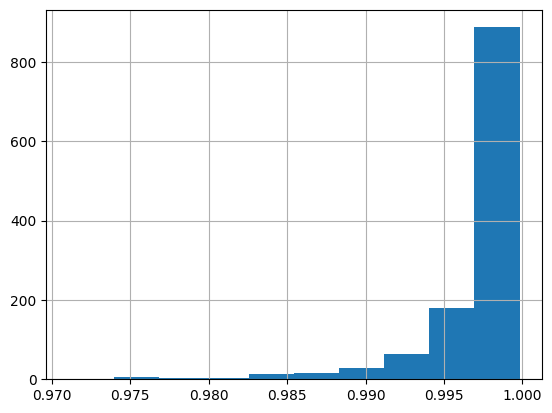

In [21]:
sample_stats.sample_call_rate.to_series().hist()

In [22]:
"""
This block reads a tab‐delimited metadata file that contains relationships 
(family IDs, individual IDs, parental IDs) and the population information for 
each individual.
"""
f = open('relationships_w_pops_041510.txt')
pop_ind = defaultdict(list)
f.readline()  # header
for line in f:
    toks = line.rstrip().split('\t')
    fam_id = toks[0]
    ind_id = toks[1]
    pop = toks[-1]
    pop_ind[pop].append((fam_id, ind_id))
f.close()
pops = list(pop_ind.keys()) # pops is a list of all population acronyms (e.g., CEU, YRI, CHB, etc.) 

In [23]:
def assign_cohort(pops, pop_ind, sample_family_id, sample_id):
    """
    This function assigns a cohort index to each sample based on its population.
    For each sample, it checks each population in pops (with an index) to see if 
    the sample’s tuple (family, individual) is found in the population’s list (pop_ind[pop]).
    The list cohort is created, containing an integer for each sample that indicates its 
    population (or cohort) as defined by the order in pops.
    """
    cohort = []
    for fid, sid in zip(sample_family_id, sample_id):
        processed = False
        for i, pop in enumerate(pops):
            if (fid, sid) in pop_ind[pop]:
                processed = True
                cohort.append(i)
                break
        if not processed:
            raise Exception(f'Not processed {fid}, {sid}')
    return cohort


cohort = assign_cohort(pops, pop_ind, data.sample_family_id.values, data.sample_id.values)

data['sample_cohort'] = xr.DataArray(cohort, dims='samples')

In [28]:
data['sample_cohort'].shape

(1198,)

In [29]:
"""
Using an sgkit function (sg.cohort_allele_frequencies), this line computes the allele 
frequencies for each variant in each cohort.
Output:
cohort_allele_frequency is a multi-dimensional NumPy array. Its dimensions typically 
correspond to (variant, cohort, allele_index).
"""
cohort_allele_frequency = sg.cohort_allele_frequencies(data)['cohort_allele_frequency'].values
cohort_allele_frequency.shape

(54999, 11, 2)

In [30]:
"""
Purpose:
This loop counts the number of variants that are monomorphic (i.e. have an allele 
frequency of exactly 0 or exactly 1) for each population.
Explanation:
For each population (indexed by i), it extracts the frequency of the first allele for all 
variants (cohort_allele_frequency[:, i, 0]).
It uses np.isin(..., [0, 1]) to create a boolean array that is True when the allele frequency 
is either 0 or 1.
The filter(lambda x: x, ...) and subsequent len(...) count the number of True values.
These counts are stored in the dictionary monom with population acronyms as keys.
Output:
A printed dictionary showing, for each population, how many variants are monomorphic.
"""
monom = {}
for i, pop in enumerate(pops):
    monom[pop] = len(list(filter(lambda x: x, np.isin(cohort_allele_frequency[:, i, 0], [0, 1]))))
pprint(monom)

{'ASW': 3303,
 'CEU': 8880,
 'CHB': 11078,
 'CHD': 12183,
 'GIH': 8915,
 'JPT': 12941,
 'LWK': 3985,
 'MEX': 6446,
 'MKK': 3432,
 'TSI': 8556,
 'YRI': 5229}


Text(0.5, 0, 'MAF')

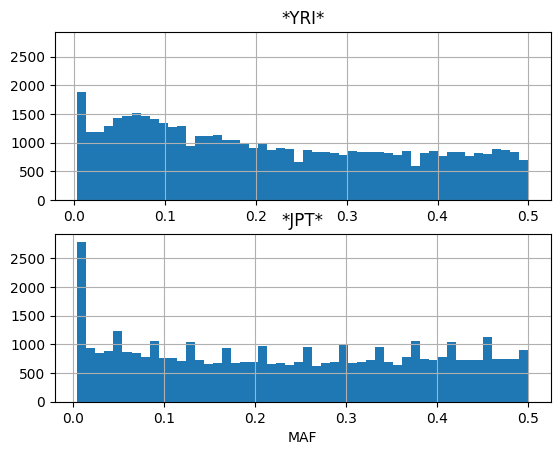

In [25]:
"""
Purpose:
This code calculates the minor allele frequency (MAF) for each variant in each population.
Explanation:
For each population (pop), it iterates over the allele frequencies (first allele, index 0) 
for all variants.
It filters out frequencies that are exactly 0 or 1 (since these are monomorphic and not 
informative for MAF).
It then maps each remaining frequency to the “minor” allele frequency:
    If the frequency is less than 0.5, it is already the minor allele frequency.
    If it is 0.5 or greater, the minor allele frequency is 1 - frequency.
These values are converted into a Pandas Series and stored in the dictionary mafs 
keyed by population.
"""
mafs = {}
for i, pop in enumerate(pops):
    min_freqs = map(lambda x: x if x < 0.5 else 1 - x, 
                    filter(lambda x: x not in [0, 1], 
                           cohort_allele_frequency[:, i, 0]))
    mafs[pop] = pd.Series(min_freqs)

maf_plot, maf_ax = plt.subplots(nrows=2, sharey=True)
mafs['YRI'].hist(ax=maf_ax[0], bins=50)
maf_ax[0].set_title('*YRI*')
mafs['JPT'].hist(ax=maf_ax[1], bins=50)
maf_ax[1].set_title('*JPT*')
maf_ax[1].set_xlabel('MAF')

In [31]:
"""
Purpose:

sg.Fst(data) calculates pairwise F_ST statistics (a measure of genetic differentiation) 
between all cohorts in the dataset.
The resulting object (an xarray Dataset) contains a variable stat_Fst with F_ST values 
for each pair of populations.

Assigning Coordinates:
The line fst = fst.assign_coords({"cohorts_0": pops, "cohorts_1": pops}) labels the 
two dimensions (representing the two populations in each pair) with the population acronyms.
Purpose:
This block filters out any NaN (not-a-number) values from the F_ST statistics for specific population pairs (CEU vs. CHB and CHB vs. CHD), converts them into Pandas Series, and then prints summary statistics (like mean, median, quartiles).
Explanation:

The lambda remove_nan uses Python’s filter to remove any values that are NaN.
For each population pair, fst.stat_Fst.sel(...) selects the F_ST values.
pd.Series(...) creates a Pandas Series, and then .describe() provides summary statistics.
"""
fst = sg.Fst(data)

fst = fst.assign_coords({"cohorts_0": pops, "cohorts_1": pops})

remove_nan = lambda data: filter(lambda x: not np.isnan(x), data)
ceu_chb = pd.Series(remove_nan(fst.stat_Fst.sel(cohorts_0='CEU', cohorts_1='CHB').values))
chb_chd = pd.Series(remove_nan(fst.stat_Fst.sel(cohorts_0='CHB', cohorts_1='CHD').values))


In [32]:
ceu_chb.describe()

count    48549.000000
mean         0.075091
std          0.095574
min         -0.004202
25%          0.006111
50%          0.040452
75%          0.107623
max          0.867424
dtype: float64

In [33]:
chb_chd.describe()

count    45155.000000
mean         0.000433
std          0.006122
min         -0.004315
25%         -0.003613
50%         -0.001659
75%          0.001748
max          0.071331
dtype: float64

In [34]:
"""
This nested loop computes the average (mean) F_ST for every unique pair of populations.
How It Works:

The outer loop iterates over each population pop_i and the inner loop iterates over 
every other population pop_j such that j > i (to avoid duplicates).
For each pair, it extracts the F_ST values, removes NaNs, converts them to a Pandas Series, 
and then computes the mean.
The means are stored in a dictionary mean_fst with keys as tuple pairs (pop_i, pop_j).
Finally, min_pair and max_pair capture the minimum and maximum of these mean F_ST values, 
which are used later for normalization in plotting.
"""
mean_fst = {}
for i, pop_i in enumerate(pops):
    for j, pop_j in enumerate(pops):
        if j <= i:
            continue
        pair_fst = pd.Series(remove_nan(fst.stat_Fst.sel(cohorts_0=pop_i, cohorts_1=pop_j).values))
        mean = pair_fst.mean()
        mean_fst[(pop_i, pop_j)] = mean

min_pair = min(mean_fst.values())
max_pair = max(mean_fst.values())

[Text(0, 0, 'ASW'),
 Text(0, 1, 'CEU'),
 Text(0, 2, 'CHB'),
 Text(0, 3, 'CHD'),
 Text(0, 4, 'GIH'),
 Text(0, 5, 'JPT'),
 Text(0, 6, 'LWK'),
 Text(0, 7, 'MEX'),
 Text(0, 8, 'MKK'),
 Text(0, 9, 'TSI')]

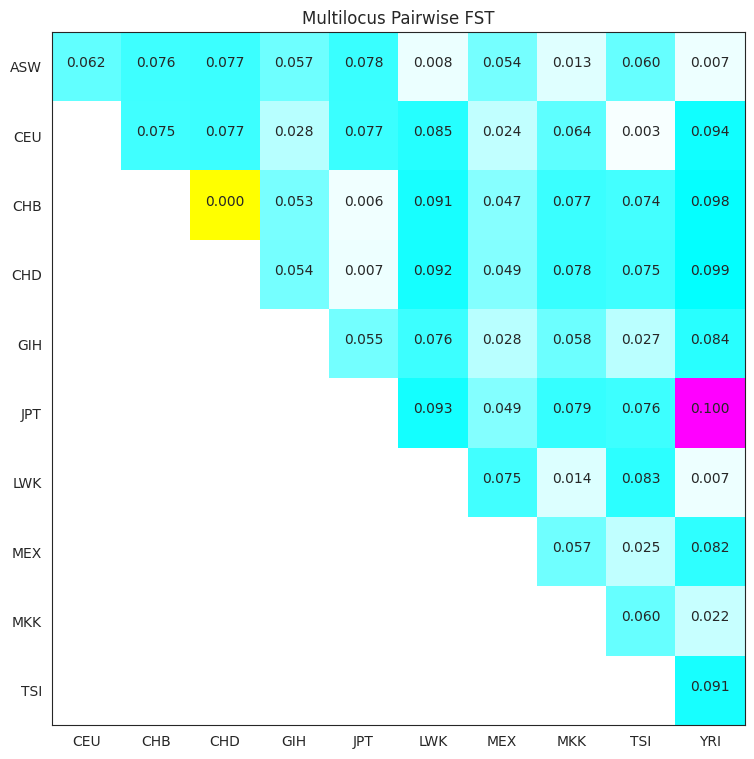

In [35]:
sns.set_style("white")
num_pops = len(pops)
arr = np.ones((num_pops - 1, num_pops - 1, 3), dtype=float)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
for row in range(num_pops - 1):
    pop_i = pops[row]
    for col in range(row + 1, num_pops):
        pop_j = pops[col]
        val = mean_fst[(pop_i, pop_j)]
        norm_val = (val - min_pair) / (max_pair - min_pair)
        ax.text(col - 1, row, '%.3f' % val, ha='center')
        if norm_val == 0.0:
            arr[row, col - 1, 0] = 1
            arr[row, col - 1, 1] = 1
            arr[row, col - 1, 2] = 0
        elif norm_val == 1.0:
            arr[row, col - 1, 0] = 1
            arr[row, col - 1, 1] = 0
            arr[row, col - 1, 2] = 1
        else:
            arr[row, col - 1, 0] = 1 - norm_val
            arr[row, col - 1, 1] = 1
            arr[row, col - 1, 2] = 1
ax.imshow(arr, interpolation='none')
ax.set_title('Multilocus Pairwise FST')
ax.set_xticks(range(num_pops - 1))
ax.set_xticklabels(pops[1:])
ax.set_yticks(range(num_pops - 1))
ax.set_yticklabels(pops[:-1])

In [37]:
f = open('relationships_w_pops_121708.txt')
ind_pop = {}
f.readline()  # header
for l in f:
    toks = l.rstrip().split('\t')
    fam_id = toks[0]
    ind_id = toks[1]
    pop = toks[-1]
    ind_pop['/'.join([fam_id, ind_id])] = pop
f.close()
ind_pop['2469/NA20281'] = ind_pop['2805/NA20281']
# -

# ## Requires plink from data preparation

# + jupyter={"outputs_hidden": false}
to_eigen('hapmap10_auto_noofs_ld_12', 'hapmap10_auto_noofs_ld_12')
# -

# ## Running smartpca

# + jupyter={"outputs_hidden": false}
ctrl = smart.SmartPCAController('hapmap10_auto_noofs_ld_12')
ctrl.run()

# + jupyter={"outputs_hidden": false}
wei, wei_perc, ind_comp = smart.parse_evec('hapmap10_auto_noofs_ld_12.evec', 'hapmap10_auto_noofs_ld_12.eval')

# + jupyter={"outputs_hidden": false}
plot.render_pca(ind_comp, 1, 2, cluster=ind_pop)
#put weights

# + jupyter={"outputs_hidden": false}
plot.render_pca_eight(ind_comp, cluster=ind_pop)

# + jupyter={"outputs_hidden": false}
markers = { 'CHB': '*', 'CHD': '*', 'JPT': '*', 'GIH': '*',
           'CEU': 'v', 'TSI': 'v', 'MEX': 'v',
           'ASW': 'o', 'LWK': 'o', 'YRI': 'o', 'MKK': 'o'
           }

KeyError: '2805/NA20281'

54999
(1198, 54999)


(<Figure size 1500x800 with 5 Axes>,
 [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >])

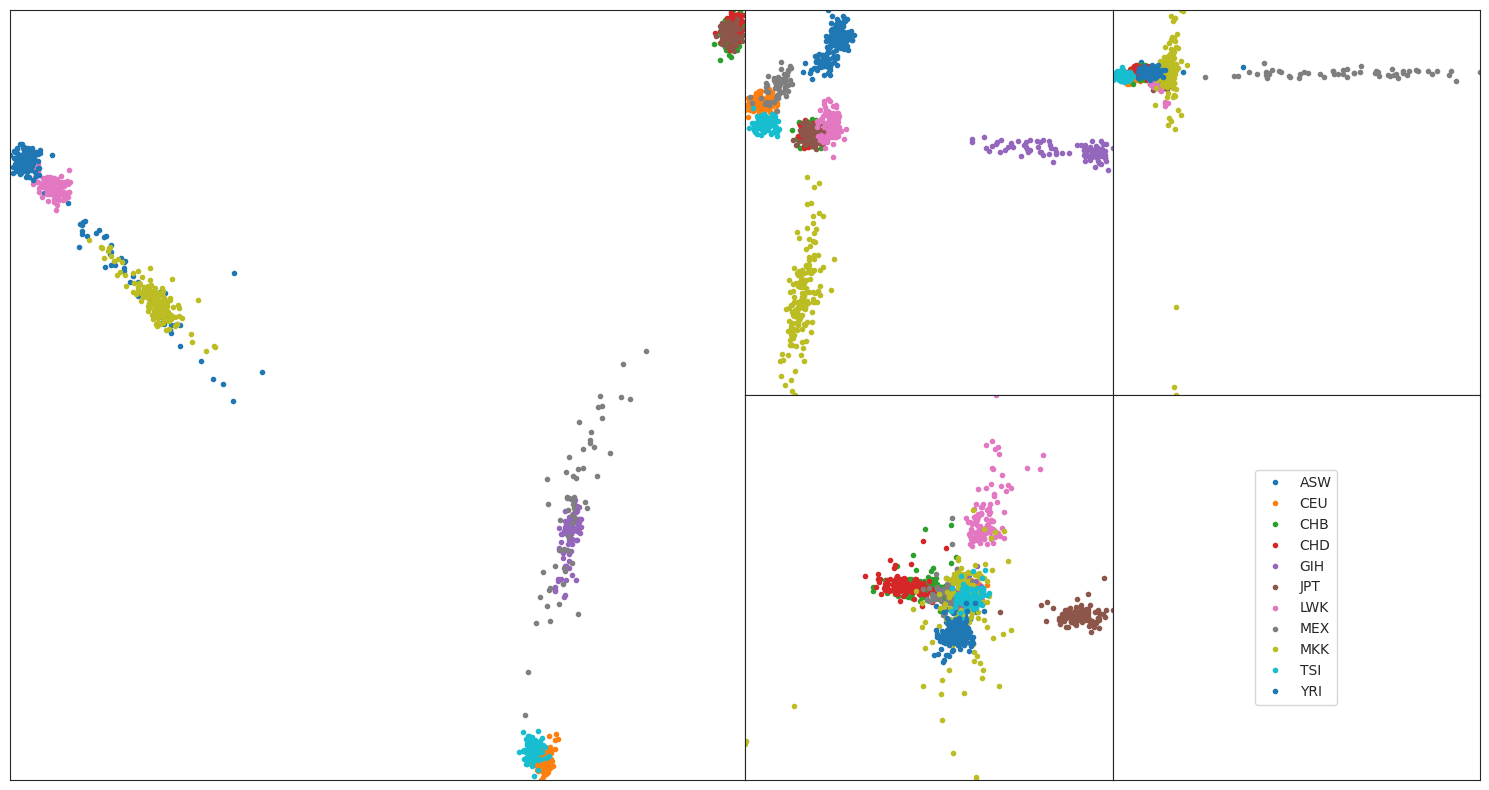

In [38]:
f = open('hapmap10_auto_noofs_ld_12.ped')
ninds = 0
ind_order = []
for line in f:
    ninds += 1
    toks = line[:100].replace(' ', '\t').split('\t') #  for speed
    fam_id = toks[0]
    ind_id = toks[1]
    ind_order.append('%s/%s' % (fam_id, ind_id))
nsnps = (len(line.replace(' ', '\t').split('\t')) - 6) // 2
print (nsnps)
f.close()

# + jupyter={"outputs_hidden": false}
pca_array = np.empty((ninds, nsnps), dtype=int)
print(pca_array.shape)
f = open('hapmap10_auto_noofs_ld_12.ped')
for ind, line in enumerate(f):
    snps = line.replace(' ', '\t').split('\t')[6:]
    for pos in range(len(snps) // 2):
        a1 = int(snps[2 * pos])
        a2 = int(snps[2 * pos])
        my_code = a1 + a2 - 2
        pca_array[ind, pos] = my_code
f.close()
#slow

# + jupyter={"outputs_hidden": false}
my_pca = PCA(n_components=8)
my_pca.fit(pca_array)
trans = my_pca.transform(pca_array)
#Memory required

# + jupyter={"outputs_hidden": false}
sc_ind_comp = {}
for i, ind_pca in enumerate(trans):
    sc_ind_comp[ind_order[i]] = ind_pca
plot.render_pca_eight(sc_ind_comp, cluster=ind_pop)
